In [15]:
!pip install evaluate transformers torch scikit-learn nltk


In [16]:
import pandas as pd
import torch
from transformers import pipeline, MarianMTModel, MarianTokenizer
from sklearn.metrics import accuracy_score, f1_score
import evaluate
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
from google.colab import files

# Upload your smaller CSV
uploaded = files.upload()  # Select train_small.csv


Saving train_small.csv to train_small (1).csv


In [18]:
import pandas as pd

# Load the small dataset
df = pd.read_csv("train_small.csv", header=None, names=["polarity", "title", "text"])

# Map polarity
df["label"] = df["polarity"].map({1: "NEGATIVE", 2: "POSITIVE"})

# Take a sample (optional, e.g., 200 rows for testing)
df_sample = df.sample(200, random_state=42).reset_index(drop=True)

df_sample.head()


,polarity,title,text,label
0,2,Every woman should buy this book!,Ever since my mother was diagnosed with breast...,POSITIVE
1,1,Worst dubbing ever!,Fast beat motivating music. Average workout. B...,NEGATIVE
2,1,Don't bother,"The pillow is tiny and poor quality foam, my p...",NEGATIVE
3,1,I'm not sure what I was expecting...but not THIS!,"Unrelated stock footage, annoying repetitive s...",NEGATIVE
4,1,Alright- Not that good,"Understood classic by others, but it bored me....",NEGATIVE


In [19]:
# Import libraries
import torch
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score

# Load sentiment analysis model
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

# Predict sentiment for the sample
predicted_labels = sentiment_model(list(df_sample["text"]))

# Convert model output to integers
predictions = [1 if p["label"] == "POSITIVE" else 0 for p in predicted_labels]
true_labels = [1 if l == "POSITIVE" else 0 for l in df_sample["label"]]

# Compute metrics
accuracy_result = accuracy_score(true_labels, predictions)
f1_result = f1_score(true_labels, predictions)

print("✅ Sentiment Analysis Completed!")
print(f"Accuracy: {accuracy_result:.4f}")
print(f"F1 Score: {f1_result:.4f}")


Device set to use cpu


✅ Sentiment Analysis Completed!
Accuracy: 0.8950
F1 Score: 0.8995


In [20]:
from transformers import MarianMTModel, MarianTokenizer
import evaluate

# Load translation model (English → Spanish)
model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Take first review for demo
text_to_translate = df_sample["text"].iloc[0]

# Tokenize and translate
inputs = tokenizer(text_to_translate, return_tensors="pt", padding=True, truncation=True)
translated_tokens = model.generate(**inputs)
translated_review = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

# Mock reference translation (for BLEU calculation)
reference_translation = ["Este producto es excelente y me encanta usarlo todos los días."]

# Compute BLEU score
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=[translated_review], references=[reference_translation])

print("Translated Review:", translated_review)
print("BLEU Score:", bleu_score)


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Translated Review: Desde que mi madre fue diagnosticada con cáncer de mama he leído casi cualquier cosa que puedo conseguir en mis manos con respecto a esta terrible enfermedad. Este libro es, con mucho, el más sobresaliente que he leído. Desearía haber mirado aquí primero. El plan de siete pasos de Joseph Keon es notable y tan fácil de leer. Lo he leído de portada a cubierta 3 o 4 veces y he probado casi todas las recetas que sugiere. Son simplemente fantásticos. He observado mi peso y ejercitado regularmente la mayor parte de mi vida.... ahora siento que, con su ayuda, estoy en el camino correcto con la nutrición, también. Si sólo todos seguiríamos su consejo, tal vez habría menos personas teniendo que lidiar con el cáncer de mama. Recomiendo encarecidamente leer este libro.
BLEU Score: {'bleu': 0.0, 'precisions': [0.03289473684210526, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 12.666666666666666, 'translation_length': 152, 'reference_length': 12}


In [21]:
from transformers import pipeline

# Load a QA model
qa_model = pipeline("question-answering", model="deepset/minilm-uncased-squad2")

# Example: pick a review from your sample
context = df_sample["text"].iloc[1]  # second review
question = "What did the reviewer like about the product?"

answer = qa_model(question=question, context=context)

print("Question:", question)
print("Answer:", answer["answer"])


Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Question: What did the reviewer like about the product?
Answer: Average workout


In [22]:
# Load summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device_map="auto")

# Pick a review to summarize
text_to_summarize = df_sample["text"].iloc[-1]  # last review

summarized_text = summarizer(text_to_summarize, max_length=15, min_length=5, do_sample=False)[0]["summary_text"]

print("Original Review:\n", text_to_summarize)
print("\nSummarized Review:\n", summarized_text)


Device set to use cpu


Original Review:
 Gladiator is one of my top favorites, but this extended version is missing DTS sound and the extended scenes aren't all that. Nothing extremely special with this version.

Summarized Review:
  Gladiator is one of my top favorites, but this extended version


In [23]:
print("✅ All tasks completed successfully!")
print(f"Sentiment Accuracy: {accuracy_result:.3f}")
print(f"Sentiment F1 Score: {f1_result:.3f}")
print(f"Translation BLEU Score: {bleu_score}")
print(f"QA Example: {answer['answer']}")
print(f"Summary Example: {summarized_text}")


✅ All tasks completed successfully!
Sentiment Accuracy: 0.895
Sentiment F1 Score: 0.900
Translation BLEU Score: {'bleu': 0.0, 'precisions': [0.03289473684210526, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 12.666666666666666, 'translation_length': 152, 'reference_length': 12}
QA Example: Average workout
Summary Example:  Gladiator is one of my top favorites, but this extended version


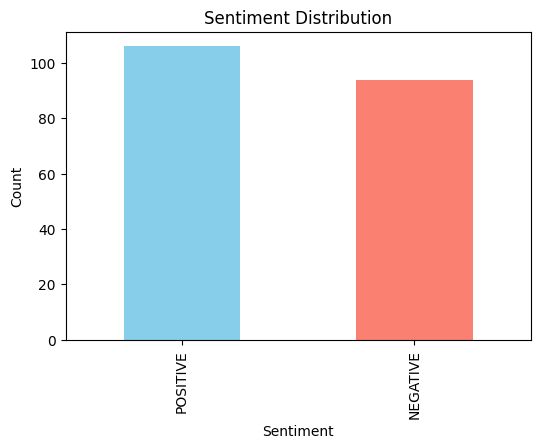

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df_sample['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], title='Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [27]:
# quick diagnostic
orig = text_to_summarize
summ = summarized_text

print("Original length (words):", len(orig.split()))
print("Summarized length (words):", len(summ.split()))
print("\nOriginal:\n", orig)
print("\nSummarized:\n", summ)


Original length (words): 28
Summarized length (words): 11

Original:
 Gladiator is one of my top favorites, but this extended version is missing DTS sound and the extended scenes aren't all that. Nothing extremely special with this version.

Summarized:
  Gladiator is one of my top favorites, but this extended version


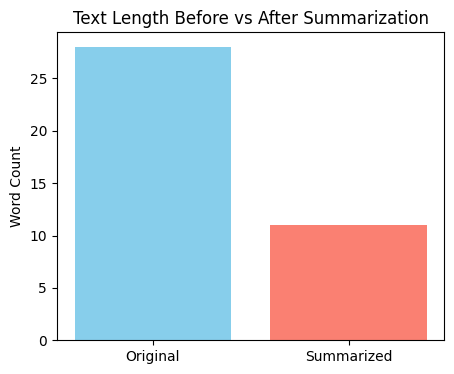

In [28]:
# Compare text length before vs after summarization
original_length = len(text_to_summarize.split())
summarized_length = len(summarized_text.split())

plt.figure(figsize=(5,4))
plt.bar(['Original', 'Summarized'], [original_length, summarized_length], color=['skyblue', 'salmon'])
plt.title('Text Length Before vs After Summarization')
plt.ylabel('Word Count')
plt.show()
